# Homework 4

## References

+ Lectures 13-16 (inclusive).


## Instructions

+ Type your name and email in the "Student details" section below.
+ Develop the code and generate the figures you need to solve the problems using this notebook.
+ For the answers that require a mathematical proof or derivation you should type them using latex. If you have never written latex before and you find it exceedingly difficult, we will likely accept handwritten solutions.
+ The total homework points are 100. Please note that the problems are not weighed equally.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
import seaborn as sns
sns.set_context("paper")
sns.set_style("ticks")

import scipy
import scipy.stats as st
import urllib.request
import os

def download(
    url : str,
    local_filename : str = None
):
    """Download a file from a url.

    Arguments
    url            -- The url we want to download.
    local_filename -- The filemame to write on. If not
                      specified
    """
    if local_filename is None:
        local_filename = os.path.basename(url)
    urllib.request.urlretrieve(url, local_filename)

## Student details

+ **First Name:** Rohan
+ **Last Name:** Dekate
+ **Email:** dekate@purdue.edu


---



---





# Problem 1 - Estimating the mechanical properties of a plastic material from molecular dynamics simulations

First, make sure that [this](https://raw.githubusercontent.com/PredictiveScienceLab/data-analytics-se/master/homework/stress_strain.txt) dataset is visible from this Jupyter notebook.
You may achieve this by either:

+ Downloading the data file and then manually upload it on Google Colab. The easiest way is to click on the folder icon on the left of the browser window and click on the upload button (or drag and drop the file). Some other options are [here](https://colab.research.google.com/notebooks/io.ipynb).
+ Downloading the file to the working directory of this notebook with this code:

In [ ]:
url = "https://github.com/PredictiveScienceLab/data-analytics-se/raw/master/lecturebook/data/stress_strain.txt"
download(url)

It's up to you what you choose to do.
If the file is in the right place, the following code should work:

In [ ]:
data =  np.loadtxt('stress_strain.txt')

The dataset was generated using a molecular dynamics simulation of a plastic material (thanks to [Professor Alejandro Strachan](https://engineering.purdue.edu/MSE/people/ptProfile?id=33239) for sharing the data!).
Specifically, Strachan's group did the following:
- They took a rectangular chunk of the material and marked the position of each one of its atoms;
- They started applying a tensile force along one dimension.
The atoms are coupled together through electromagnetic forces, and they must all satisfy Newton's law of motion.
- For each value of the applied tensile force, they marked the stress (force be unit area) in the middle of the material and the corresponding strain of the material (percent elongation in the pulling direction).
- Eventually, the material entered the plastic regime and broke.
Here is a visualization of the data:

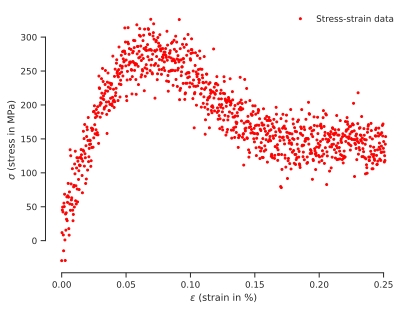

In [ ]:
# Strain
x = data[:, 0]
# Stress in MPa
y = data[:, 1]

plt.figure()
plt.plot(
    x,
    y,
    'ro',
    markersize=2,
    label='Stress-strain data'
)
plt.xlabel('$\epsilon$ (strain in %)')
plt.ylabel('$\sigma$ (stress in MPa)')
plt.legend(loc='best', frameon=False)
sns.despine(trim=True);

Note that you don't necessarily get a unique stress for each particular value of the strain.
This is because the atoms are jiggling around due to thermal effects.
So, there is always this "jiggling" noise when measuring the stress and the strain.
We want to process this noise to extract what is known as the [stress-strain curve](https://en.wikipedia.org/wiki/Stress–strain_curve) of the material.
The stress-strain curve is a macroscopic property of the material, affected by the fine structure, e.g., the chemical bonds, the crystalline structure, any defects, etc.
It is a required input to the mechanics of materials.

## Part A - Fitting the stress-strain curve in the elastic regime
The very first part of the stress-strain curve should be linear.
It is called the *elastic regime*.
In that region, say $\epsilon < \epsilon_l=0.04$, the relationship between stress and strain is:

$$
\sigma(\epsilon) = E\epsilon.
$$

The constant $E$ is known as the *Young modulus* of the material.
Assume that you measure $\epsilon$ without noise, but your measured $\sigma$ is noisy.

### Subpart A.I
First, extract the relevant data for this problem, split it into training and validation datasets, and visualize the training and validation datasets using different colors.

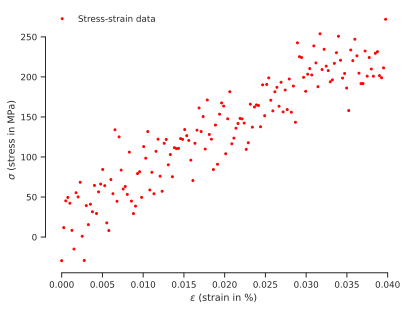

In [ ]:
# The point at which the stress-strain curve stops being linear
epsilon_l = 0.04
# Relevant data (this is nice way to get the linear part of the stresses and straints)
x_rel = x[x < 0.04]
y_rel = y[x < 0.04]

# Visualize to make sure you have the right data
plt.figure()
plt.plot(
    x_rel,
    y_rel,
    'ro',
    markersize=2,
    label='Stress-strain data'
)
plt.xlabel('$\epsilon$ (strain in %)')
plt.ylabel('$\sigma$ (stress in MPa)')
plt.legend(loc='best', frameon=False)
sns.despine(trim=True);

Split your data into training and validation.

**Hint:** You may use [sklearn.model_selection.train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) if you wish.

In [ ]:
# Split the data into training and validation datasets
# Hint: Consult the lecture notes
from sklearn.model_selection import train_test_split
x_train, x_valid, y_train, y_valid = train_test_split(x_rel, y_rel, test_size=0.33, random_state=42)
print(f"Training Data Shape: {x_train.shape, y_train.shape}")
print(f"Validation Data Shape: {x_valid.shape, y_valid.shape}")
# What should be the test size?

Training Data Shape: ((106,), (106,))
Validation Data Shape: ((53,), (53,))


Use the following to visualize your split:

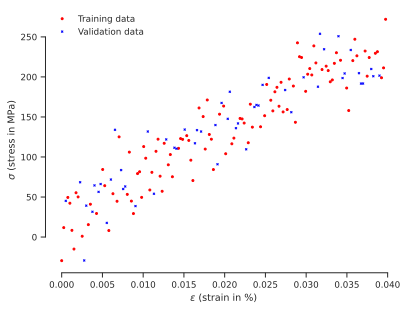

In [ ]:
plt.figure()
plt.plot(
    x_train,
    y_train,
    'ro',
    markersize=2,
    label='Training data'
)
plt.plot(
    x_valid,
    y_valid,
    'bx',
    markersize=2,
    label='Validation data'
)
plt.xlabel('$\epsilon$ (strain in %)')
plt.ylabel('$\sigma$ (stress in MPa)')
plt.legend(loc='best', frameon=False)
sns.despine(trim=True);

In [ ]:
def get_polynomial_design_matrix(x, degree):
    """Return the polynomial design matrix of ``degree`` evaluated at ``x``.

    Arguments:
    x      -- A 2D array with only one column.
    degree -- An integer greater than zero.
    """
    assert isinstance(x, np.ndarray), 'x is not a numpy array.'
    assert x.ndim == 2, 'You must make x a 2D array.'
    assert x.shape[1] == 1, 'x must be a column.'
    cols = []
    for i in range(degree+1):
        cols.append(x ** i)
    return np.hstack(cols)

### Subpart A.II
Perform Bayesian linear regression with the evidence approximation to estimate the noise variance and the hyperparameters of the prior.

In [ ]:
# Your code here
from sklearn.linear_model import BayesianRidge

# Parameters
degree = 1

# Design matrix
Phi = get_polynomial_design_matrix(x_train[:, None], degree)

# Fit
model = BayesianRidge(
    fit_intercept=False
).fit(Phi, y_train)

# From scikit-learn: model.alpha_ is
# the "Estimated precision of the noise."
sigma = np.sqrt(1.0 / model.alpha_)
print(f'sigma = {sigma:1.2f}')

# It calls it lambda...
alpha = np.sqrt(1/model.lambda_) # Told by TAs during Office Hours
print(f'alpha = {alpha:f}')

# m = model.coef_
# print(f"Posterior mean w: {m}")

# S = model.sigma_
# print(f"Posterior covariance w:")
# print(S)

sigma = 25.61
alpha = 4002.568279


### Subpart A.III
Calculate the mean square error of the validation data.

In [ ]:
# your code here
Phi_valid = get_polynomial_design_matrix(
    x_valid[:, None],
    degree
)
y_predict, y_std = model.predict(
    Phi_valid,
    return_std=True
)

MSE_val = np.mean((y_predict - y_valid) ** 2)
print(f'MSE of Validation Data = {MSE_val:1.2f}')

MSE of Validation Data = 834.63


### Subpart A.IV
Make the observations vs predictions plot for the validation data.

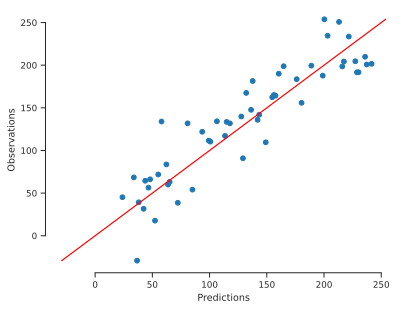

In [ ]:
# your code here
fig, ax = plt.subplots()
ax.plot(y_predict, y_valid, 'o')
yys = np.linspace(
    y_valid.min(),
    y_valid.max(),
    100)
ax.plot(yys, yys, 'r-')
ax.set_xlabel('Predictions')
ax.set_ylabel('Observations')
sns.despine(trim=True);

### Subpart A.V
Compute and plot the standardized errors for the validation data.

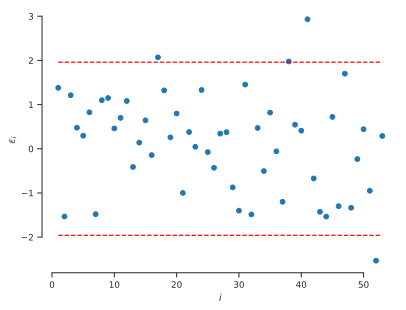

In [ ]:
# your code here
eps = (y_valid - y_predict) / y_std
idx = np.arange(1, eps.shape[0] + 1)

fig, ax = plt.subplots()
ax.plot(idx, eps, 'o', label='Standarized errors')
ax.plot(idx, 1.96 * np.ones(eps.shape[0]), 'r--')
ax.plot(idx, -1.96 * np.ones(eps.shape[0]), 'r--')
ax.set_xlabel('$i$')
ax.set_ylabel('$\epsilon_i$')
sns.despine(trim=True);

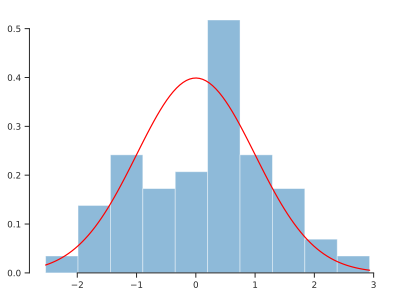

In [ ]:
import scipy.stats as st

fig, ax = plt.subplots()
ax.hist(eps, alpha=0.5, density=True)
ee = np.linspace(eps.min(), eps.max(), 100)
ax.plot(ee, st.norm.pdf(ee), 'r')
sns.despine(trim=True);

### Subpart A.VI
Make the quantile-quantile plot of the standardized errors.

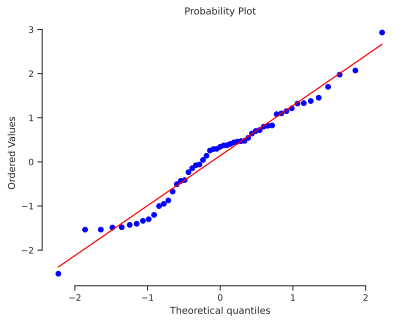

In [ ]:
# your code here
fig, ax = plt.subplots()
st.probplot(eps, dist=st.norm, plot=ax)
sns.despine(trim=True);

### Subpart A.VII
Visualize your epistemic and the aleatory uncertainty about the stress-strain curve in the elastic regime.

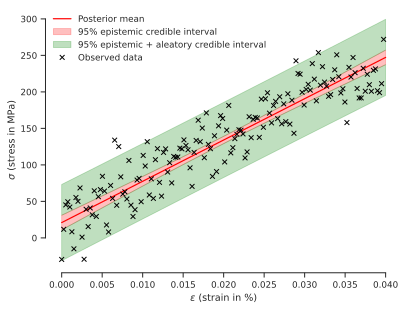

In [ ]:
# your code here
xx = np.linspace(0, 0.04, y_rel.shape[0])
Phi_xx = get_polynomial_design_matrix(xx[:, None], degree)

# Predict with model
yy_mean, yy_measured_std = model.predict(
    Phi_xx,
    return_std=True
)

# Extract epistemic predictive standard deviation
yy_std = np.sqrt(yy_measured_std ** 2 - sigma**2)
# Epistemic 95% credible interval
yy_le = yy_mean - 2.0 * yy_std
yy_ue = yy_mean + 2.0 * yy_std
# Epistemic + aleatory 95% credible interval
yy_lae = yy_mean - 2.0 * yy_measured_std
yy_uae = yy_mean + 2.0 * yy_measured_std

# The true response
yy_true = y_rel

# Plot
fig, ax = plt.subplots()
ax.plot(xx, yy_mean, 'r', label="Posterior mean")
ax.fill_between(
    xx,
    yy_le,
    yy_ue,
    color='red',
    alpha=0.25,
    label="95% epistemic credible interval"
)
ax.fill_between(
    xx,
    yy_lae,
    yy_le,
    color='green',
    alpha=0.25
)
ax.fill_between(
    xx,
    yy_ue,
    yy_uae,
    color='green',
    alpha=0.25,
    label="95% epistemic + aleatory credible interval"
)
ax.plot(x_rel, y_rel, 'kx', label='Observed data')
# ax.plot(xx, yy_true, "--", label="True response")
ax.set_xlabel('$\epsilon$ (strain in %)')
ax.set_ylabel('$\sigma$ (stress in MPa)')
plt.legend(loc="best", frameon=False)
sns.despine(trim=True);

### Subpart A. VIII
Visualize the posterior of the Young modulus E conditioned on the data.

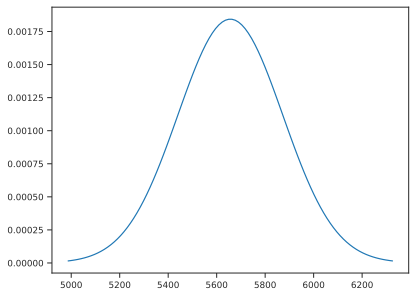

In [ ]:
# your code here
# Visualize the PDF
m_post = model.coef_
cov_post = model.sigma_
e_post = st.norm(loc=m_post[1],scale=np.sqrt(cov_post[1,1]))
e_points = np.linspace(e_post.ppf(.001),e_post.ppf(0.999),100)
plt.plot(e_points,e_post.pdf(e_points))

### Subpart A.IX
Take five samples of stress-strain curve in the elastic regime and visualize them.

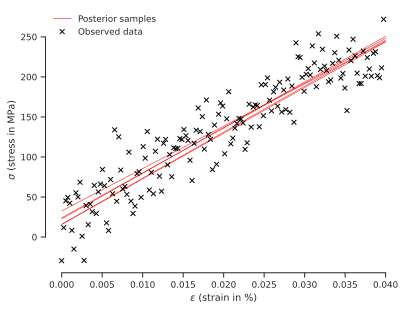

In [ ]:
# your code here
import scipy.stats as st

m = model.coef_
# print(f"Posterior mean w: {m}")
S = model.sigma_
# print(f"Posterior covariance w:")
# print(S)
w_post = st.multivariate_normal(mean=m, cov=S)
# If you get an error because the covariance matrix is singular, add something small
# to the diagonal. The covariance matrix is always positive definite (and non-singular)
# but it may have eigenvalues so close to zero that the numerical algorithms find
# them to be slightly negative. This is an artifact of the floating point precision.
# Comment the line above and uncomment the line below to fix the problem.
# w_post = st.multivariate_normal(mean=m, cov=S + 1e-6 * np.eye(S_norm.shape[0]))

# Plot
fig, ax = plt.subplots()
for _ in range(5):
    w_sample = w_post.rvs()
    yy_sample = Phi_xx @ w_sample
    ax.plot(xx, yy_sample, 'r', lw=0.5)
ax.plot([], [], "r", lw=0.5, label="Posterior samples")
ax.plot(x_rel, y_rel, 'kx', label='Observed data')
# ax.plot(xx, yy_true, label='True response surface')
ax.set_xlabel('$\epsilon$ (strain in %)')
ax.set_ylabel('$\sigma$ (stress in MPa)')
plt.legend(loc="best", frameon=False)
sns.despine(trim=True);

### Subpart A.X

Find the 95% centered credible interval for the Young modulus $E$.

In [ ]:
# your code here
E_low = e_post.ppf(0.025)
E_up = e_post.ppf(0.975)
print(f'Youngs Modulus is in [{E_low:.2f}, {E_up:1.2f}] with 95% probability')

Youngs Modulus is in [5232.08, 6080.54] with 95% probability


### Subpart A.XI
If you had to pick a single value for the Young modulus $E$, what would it be and why?

In [ ]:
# your code here
e_post.ppf(0.5)

5656.30820242644

*Your answer here*
I'll pick the median value as the Young's Modulus as this closer to the mean (because the distribution is Gaussian).

## Part B - Estimate the ultimate strength

The pick of the stress-strain curve is known as the ultimate strength.
We want to estimate it.

### Subpart B.I - Extract training and validation data

Extract training and validation data from the entire dataset.

In [ ]:
url = "https://github.com/PredictiveScienceLab/data-analytics-se/raw/master/lecturebook/data/stress_strain.txt"
download(url)

data =  np.loadtxt('stress_strain.txt')

# Strain
x = data[:, 0]
# Stress in MPa
y = data[:, 1]

In [ ]:
# your code here - Repeat as many text and code blocks as you like
x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=0.33, random_state=42)
print(f"Training Data Shape: {x_train.shape, y_train.shape}")
print(f"Validation Data Shape: {x_valid.shape, y_valid.shape}")
# x_train, y_train, x_valid, y_valid = # Your code

Training Data Shape: ((670,), (670,))
Validation Data Shape: ((331,), (331,))


Use the following to visualize your split:

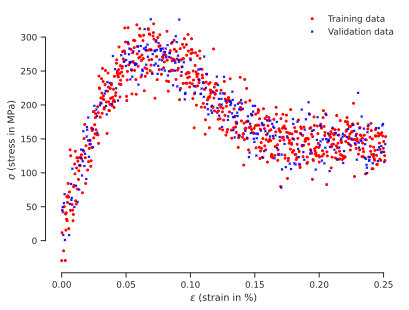

In [ ]:
plt.figure()
plt.plot(
    x_train,
    y_train,
    'ro',
    markersize=2,
    label='Training data'
)
plt.plot(
    x_valid,
    y_valid,
    'bx',
    markersize=2,
    label='Validation data'
)
plt.xlabel('$\epsilon$ (strain in %)')
plt.ylabel('$\sigma$ (stress in MPa)')
plt.legend(loc='best', frameon=False)
sns.despine(trim=True);

### Subpart B.II - Model the entire stress-strain relationship.
To do this, we will set up a generalized linear model to capture the entire stress-strain relationship.
Remember, you can use any model you want as soon as:
+ It is linear in the parameters to be estimated,
+ It has a well-defined elastic regime (see Part A).

I am going to help you set up the right model.
We will use the [Heavide step function](https://en.wikipedia.org/wiki/Heaviside_step_function) to turn on or off models for various ranges of $\epsilon$. The idea is quite simple: We will use a linear model for the elastic regime, and we are going to turn to a non-linear model for the non-linear regime.
Here is a model that has the right form in the elastic regime and an arbitrary form in the non-linear regime:

$$
f(\epsilon;E,\mathbf{w}_g) = E\epsilon \left[(1 - H(\epsilon - \epsilon_l)\right] + g(\epsilon;\mathbf{w}_g)H(\epsilon - \epsilon_l),
$$

where

$$
H(x) = \begin{cases}
0,\;\text{if}\;x < 0\\
1,\;\text{otherwise},
\end{cases}
$$

and $g$ is any function linear in the parameters $\mathbf{w}_g$.

You can use any model you like for the non-linear regime, but let's use a polynomial of degree $d$:

$$
g(\epsilon) = \sum_{i=0}^{d} w_i \epsilon^i.
$$

The full model can be expressed as:

$$
\begin{split}
f(\epsilon) &=
\begin{cases}
h(\epsilon) = E \epsilon,\ \epsilon < \epsilon_l, \\
g(\epsilon) = \sum_{i=0}^{d} w_i \epsilon^i, \epsilon \geq \epsilon_l
\end{cases}\\
&= E\epsilon \left(1 - H(\epsilon - \epsilon_l)\right) + \sum_{i=0}^{d} w_i \epsilon^iH(\epsilon - \epsilon_l).
\end{split}
$$

We could proceed with this model, but there is a small problem: It is discontinuous at $\epsilon = \epsilon_l$.
This is unphysical. We can do better than that!

To make the model nice, we force the $h$ and $g$ to match up to the first derivative, i.e., we demand that:

$$
\begin{split}
h(\epsilon_l) &= g(\epsilon_l)\\
h'(\epsilon_l) &= g'(\epsilon_l).
\end{split}
$$

We include the first derivative because we don't have a kink in the stress-strain. That would also be unphysical.
The two equations above become:

$$
\begin{split}
E\epsilon_l &= \sum_{i=0}^dw_i\epsilon_l^i\\
E &= \sum_{i=1}^diw_i\epsilon_l^{i-1}.
\end{split}
$$

We can use these two equations to eliminate two weights.
Let's eliminate $w_0$ and $w_1$.
All you have to do is express them in terms of $E$ and $w_2,\dots,w_d$.
So, there remain $d$ parameters to estimate.
Let's get back to the stress-strain model.

Our stress-strain model was:

$$
f(\epsilon) = E\epsilon \left(1 - H(\epsilon - \epsilon_l)\right) + \sum_{i=0}^{d} w_i \epsilon^iH(\epsilon - \epsilon_l).
$$

We can now use the expressions for $w_0$ and $w_1$ to rewrite this using only all the other
parameters.
I am going to spare you the details.
The result is:

$$
f(\epsilon) = E\epsilon + \sum_{i=2}^dw_i\left[(i-1)\epsilon_{l}^{i} - i \epsilon \epsilon_{l}^{i-1} + \epsilon^i\right]H(\epsilon - \epsilon_l).
$$

Okay.
This is still a generalized linear model. This is nice.
Write code for the design matrix:

In [ ]:
# Complete this code to make your model:
def compute_design_matrix(Epsilon, epsilon_l, d):
    """Compute the design matrix for the stress-strain curve problem.

    Arguments:
        Epsilon     -     A 1D array of dimension N.
        epsilon_l   -     The strain signifying the end of the elastic regime.
        d           -     The polynomial degree.

    Returns:
        A design matrix N x d
    """
    # Sanity check
    assert isinstance(Epsilon, np.ndarray)
    assert Epsilon.ndim == 1, 'Pass the array as epsilon.flatten(), if it is two dimensional'
    n = Epsilon.shape[0]
    # The design matrix:
    Phi = np.ndarray((n, d))
    # The step function evaluated at all the elements of Epsilon.
    # You can use it if you want.
    Step = np.ones(n)
    Step[Epsilon < epsilon_l] = 0
    # Build the design matrix
    Phi[:, 0] = Epsilon# Your code here
    for i in range(2, d+1):
        Phi[:, i-1] = ((i-1)*epsilon_l**i - i*Epsilon*epsilon_l**(i-1)+Epsilon**(i))*Step# Your code here
    return Phi

Visualize the basis functions here:

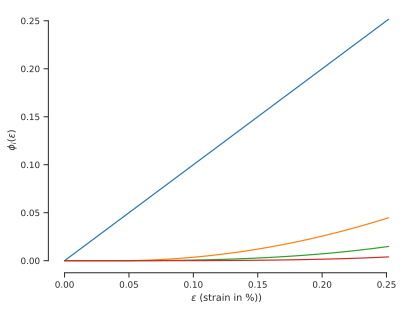

In [ ]:
d = 4
eps = np.linspace(0, x.max(), 100)
Phis = compute_design_matrix(eps, epsilon_l, d)
fig, ax = plt.subplots(dpi=100)
ax.plot(eps, Phis)
ax.set_xlabel('$\epsilon$ (strain in %))')
ax.set_ylabel('$\phi_i(\epsilon)$')
sns.despine(trim=True);

### Subpart B.III

Fit the model using automatic relevance determination and demonstrate that it works well by doing everything we did above (MSE, observations vs. predictions plot, standardized errors, etc.).

In [ ]:
# Your code here - Use as many blocks as you need!
from sklearn.linear_model import ARDRegression

# Parameters
degree = 4

# Design matrix
Phi = compute_design_matrix(x_train,epsilon_l,degree)

model = ARDRegression(
        fit_intercept=False
      ).fit(Phi, y_train)# Just call the resulting model "model"

# the "Estimated precision of the noise."
sigma = np.sqrt(1.0 / model.alpha_)
print(f'sigma = {sigma:1.2f}')

# It calls it lambda...
alpha = np.sqrt(1/model.lambda_)
# print(f'alpha = {alpha}')

m = model.coef_
# print(f"Posterior mean w: {m}")

S = model.sigma_
# print(f"Posterior covariance w:")
# print(S)

sigma = 27.16


In [ ]:
# your code here
Phi_valid = compute_design_matrix(x_valid,epsilon_l,degree)

y_predict, y_std = model.predict(
    Phi_valid,
    return_std=True
)

MSE_val = np.mean((y_predict - y_valid) ** 2)
print(f'MSE of Validation Data = {MSE_val:1.2f}')

MSE of Validation Data = 685.65


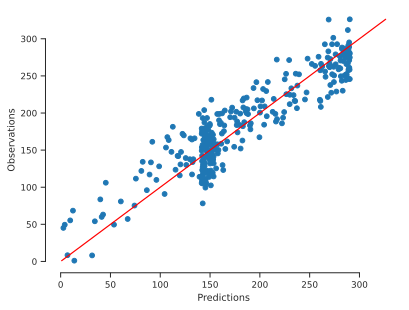

In [ ]:
# your code here
fig, ax = plt.subplots()
ax.plot(y_predict, y_valid, 'o')
yys = np.linspace(
    y_valid.min(),
    y_valid.max(),
    100)
ax.plot(yys, yys, 'r-')
ax.set_xlabel('Predictions')
ax.set_ylabel('Observations')
sns.despine(trim=True);

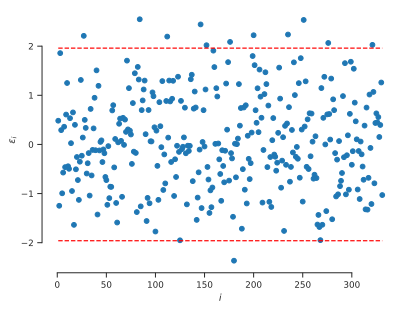

In [ ]:
# your code here
eps = (y_valid - y_predict) / y_std
idx = np.arange(1, eps.shape[0] + 1)

fig, ax = plt.subplots()
ax.plot(idx, eps, 'o', label='Standarized errors')
ax.plot(idx, 1.96 * np.ones(eps.shape[0]), 'r--')
ax.plot(idx, -1.96 * np.ones(eps.shape[0]), 'r--')
ax.set_xlabel('$i$')
ax.set_ylabel('$\epsilon_i$')
sns.despine(trim=True);

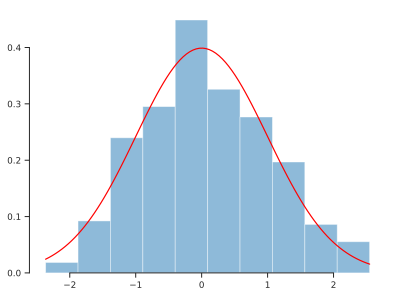

In [ ]:
import scipy.stats as st

fig, ax = plt.subplots()
ax.hist(eps, alpha=0.5, density=True)
ee = np.linspace(eps.min(), eps.max(), 100)
ax.plot(ee, st.norm.pdf(ee), 'r')
sns.despine(trim=True);

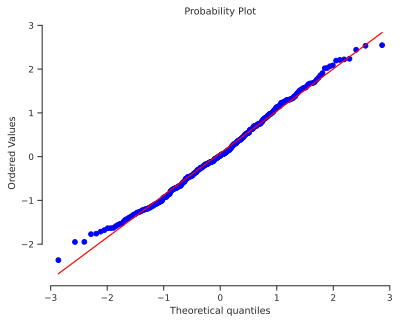

In [ ]:
# your code here
fig, ax = plt.subplots()
st.probplot(eps, dist=st.norm, plot=ax)
sns.despine(trim=True);

### Subpart B.IV
Visualize the epistemic and aleatory uncertainty in the stess-strain relation.

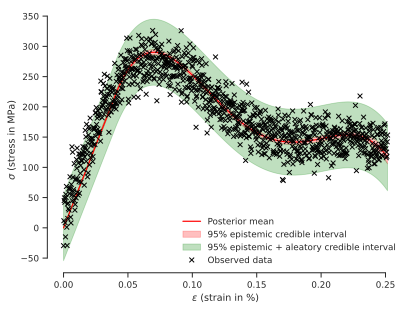

In [ ]:
# Your code here
xx = np.linspace(0, x.max(), y.shape[0])
Phi_xx = compute_design_matrix(xx,epsilon_l,degree)

# Predict with model
yy_mean, yy_measured_std = model.predict(
    Phi_xx,
    return_std=True
)

# Extract epistemic predictive standard deviation
yy_std = np.sqrt(yy_measured_std ** 2 - sigma**2)
# Epistemic 95% credible interval
yy_le = yy_mean - 2.0 * yy_std
yy_ue = yy_mean + 2.0 * yy_std
# Epistemic + aleatory 95% credible interval
yy_lae = yy_mean - 2.0 * yy_measured_std
yy_uae = yy_mean + 2.0 * yy_measured_std

# The true response
yy_true = y

# Plot
fig, ax = plt.subplots()
ax.plot(xx, yy_mean, 'r', label="Posterior mean")
ax.fill_between(
    xx,
    yy_le,
    yy_ue,
    color='red',
    alpha=0.25,
    label="95% epistemic credible interval"
)
ax.fill_between(
    xx,
    yy_lae,
    yy_le,
    color='green',
    alpha=0.25
)
ax.fill_between(
    xx,
    yy_ue,
    yy_uae,
    color='green',
    alpha=0.25,
    label="95% epistemic + aleatory credible interval"
)
ax.plot(x, y, 'kx', label='Observed data')
# ax.plot(xx, yy_true, "--", label="True response")
plt.xlabel('$\epsilon$ (strain in %)')
plt.ylabel('$\sigma$ (stress in MPa)')
plt.legend(loc="best", frameon=False)
sns.despine(trim=True);

### Subpart B.V - Extract the ultimate strength

Now, you will quantify your epistemic uncertainty about the ultimate strength.
The ultimate strength is the maximum of the stress-strain relationship.
Since you have epistemic uncertainty about the stress-strain relationship, you also have epistemic uncertainty about the ultimate strength.

Do the following:
- Visualize the posterior of the ultimate strength.
- Find a 95% credible interval for the ultimate strength.
- Pick a value for the ultimate strength.

**Hint:**
To characterize your epistemic uncertainty about the ultimate strength, you would have to do the following:
- Define a dense set of strain points between 0 and 0.25.
- Repeatedly:
 + Sample from the posterior of the weights of your model
 + For each sample, evaluate the stresses at the dense set of strain points defined earlier
 + For each sampled stress vector, find the maximum. This is a sample of the ultimate strength.

In [ ]:
# Enter your code here
strain_points = np.linspace(0, 0.25, 10000)
Phi_xx = compute_design_matrix(strain_points,epsilon_l,degree)

import scipy.stats as st
m = model.coef_
S = model.sigma_
w_post = st.multivariate_normal(mean=m, cov=S)
# w_post = st.multivariate_normal(mean=m, cov=S + 1e-6 * np.eye(S.shape[0]))

ultimate_strength = []

for _ in range(1000):
    w_sample = w_post.rvs() # Sampling from posterior of weights
    yy_sample = Phi_xx @ w_sample # Evaluate Stress
    max_stress = np.max(yy_sample) # Maximum of sampled stress vector
    ultimate_strength.append(max_stress)
# print(ultimate_strength)

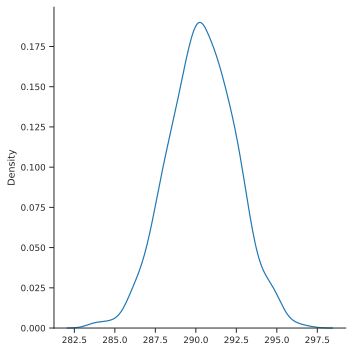

In [ ]:
# e_post = st.norm(loc=m_post[1],scale=np.sqrt(cov_post[1,1]))
# e_points = np.linspace(e_post.ppf(.001),e_post.ppf(0.999),100)
# plt.plot(e_points,e_post.pdf(e_points))
# sns.kdeplot(ultimate_strength)
sns.displot(ultimate_strength, kind="kde")

In [ ]:
from re import U
mu = np.mean(ultimate_strength)
std = np.std(ultimate_strength)
u_post = st.norm(loc=mu,scale=std)

# your code here
U_low = u_post.ppf(0.025)
U_up = u_post.ppf(0.975)
print(f'Ultimate Strength is in [{U_low:.2f}, {U_up:1.2f}] with 95% probability')

print(f"Picking the Median value of Ultimate Strength as: {u_post.ppf(0.5)}")

Ultimate Strength is in [286.32, 294.43] with 95% probability
Picking the Median value of Ultimate Strength as: 290.37911767022007




---


$\pagebreak$

# Problem 2 - Optimizing the performance of a compressor

In this problem, we will need [this](https://raw.githubusercontent.com/PredictiveScienceLab/data-analytics-se/master/homework/compressor_data.xlsx) dataset. The dataset was kindly provided to us by [Professor Davide Ziviani](https://scholar.google.com/citations?user=gPdAtg0AAAAJ&hl=en).
As before, you can either put it on your Google Drive or just download it with the code segment below:

In [ ]:
url = "https://github.com/PredictiveScienceLab/data-analytics-se/raw/master/lecturebook/data/compressor_data.xlsx"
download(url)

Note that this is an Excel file, so we need pandas to read it.
Here is how:

In [ ]:
import pandas as pd
data = pd.read_excel('compressor_data.xlsx')
data

,T_e,DT_sh,T_c,DT_sc,T_amb,f,m_dot,m_dot.1,Capacity,Power,Current,COP,Efficiency
0,-30,11,25,8,35,60,28.8,8.000000,1557,901,4.4,1.73,0.467
1,-30,11,30,8,35,60,23.0,6.388889,1201,881,4.0,1.36,0.425
2,-30,11,35,8,35,60,17.9,4.972222,892,858,3.7,1.04,0.382
3,-25,11,25,8,35,60,46.4,12.888889,2509,1125,5.3,2.23,0.548
4,-25,11,30,8,35,60,40.2,11.166667,2098,1122,5.1,1.87,0.519
...,...,...,...,...,...,...,...,...,...,...,...,...,...
60,10,11,45,8,35,60,245.2,68.111111,12057,2525,11.3,4.78,0.722
61,10,11,50,8,35,60,234.1,65.027778,10939,2740,12.3,3.99,0.719
62,10,11,55,8,35,60,222.2,61.722222,9819,2929,13.1,3.35,0.709
63,10,11,60,8,35,60,209.3,58.138889,8697,3091,13.7,2.81,0.693


The data are part of an experimental study of a variable-speed reciprocating compressor.
The experimentalists varied two temperatures, $T_e$ and $T_c$ (both in C), and they measured various other quantities.
We aim to learn the map between $T_e$ and $T_c$ and measure Capacity and Power (both in W).
First, let's see how you can extract only the relevant data.

In [ ]:
# Here is how to extract the T_e and T_c columns and put them in a single numpy array
x = data[['T_e','T_c']].values
x

array([[-30,  25],
       [-30,  30],
       [-30,  35],
       [-25,  25],
       [-25,  30],
       [-25,  35],
       [-25,  40],
       [-25,  45],
       [-20,  25],
       [-20,  30],
       [-20,  35],
       [-20,  40],
       [-20,  45],
       [-20,  50],
       [-15,  25],
       [-15,  30],
       [-15,  35],
       [-15,  40],
       [-15,  45],
       [-15,  50],
       [-15,  55],
       [-10,  25],
       [-10,  30],
       [-10,  35],
       [-10,  40],
       [-10,  45],
       [-10,  50],
       [-10,  55],
       [-10,  60],
       [ -5,  25],
       [ -5,  30],
       [ -5,  35],
       [ -5,  40],
       [ -5,  45],
       [ -5,  50],
       [ -5,  55],
       [ -5,  60],
       [ -5,  65],
       [  0,  25],
       [  0,  30],
       [  0,  35],
       [  0,  40],
       [  0,  45],
       [  0,  50],
       [  0,  55],
       [  0,  60],
       [  0,  65],
       [  5,  25],
       [  5,  30],
       [  5,  35],
       [  5,  40],
       [  5,  45],
       [  5,

In [ ]:
# Here is how to extract the Capacity
y = data['Capacity'].values
y

array([ 1557,  1201,   892,  2509,  2098,  1726,  1398,  1112,  3684,
        3206,  2762,  2354,  1981,  1647,  5100,  4547,  4019,  3520,
        3050,  2612,  2206,  6777,  6137,  5516,  4915,  4338,  3784,
        3256,  2755,  8734,  7996,  7271,  6559,  5863,  5184,  4524,
        3883,  3264, 10989, 10144,  9304,  8471,  7646,  6831,  6027,
        5237,  4461, 13562, 12599, 11633, 10668,  9704,  8743,  7786,
        6835,  5891, 16472, 15380, 14279, 13171, 12057, 10939,  9819,
        8697,  7575])

Fit the following multivariate polynomial model to **both the Capacity and the Power**:

$$
y = w_1 + w_2T_e + w_3 T_c + w_4 T_eT_c + w_5 T_e^2 + w_6T_c^2 + w_7 T_e^2T_c + w_8T_eT_c^2 + w_9 T_e^3 + w_{10}T_c^3 + \epsilon,
$$

where $\epsilon$ is a Gaussian noise term with unknown variance.

**Hints:**
+ You may use [sklearn.preprocessing.PolynomialFeatures](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html) to construct the design matrix of your polynomial features. Do not program the design matrix by hand.
+ You should split your data into training and validation and use various validation metrics to ensure your models make sense.
+ Use [ARD Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ARDRegression.html#sklearn.linear_model.ARDRegression) to fit any hyperparameters and the noise.

### Subpart A.I - Fit the capacity

Please don't just fit. Split in training and test and use all the usual diagnostics.

In [ ]:
# your code here - Repeat as many text and code blocks as you like
from sklearn.model_selection import train_test_split
x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=0.33, random_state=42)
print(f"Training Data Shape: {x_train.shape, y_train.shape}")
print(f"Validation Data Shape: {x_valid.shape, y_valid.shape}")

Training Data Shape: ((43, 2), (43,))
Validation Data Shape: ((22, 2), (22,))


In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import ARDRegression

# Parameters
degree = 3

# Design matrix
poly = PolynomialFeatures(degree)
# print(poly)
x_train = poly.fit_transform(x_train)
# print(x_train)
# Fit
model = ARDRegression(
    fit_intercept=False
).fit(x_train, y_train)

In [ ]:
# your code here
poly_valid = poly.fit_transform(x_valid)

y_predict, y_std = model.predict(
    poly_valid,
    return_std=True
)

MSE_val = np.mean((y_predict - y_valid) ** 2)
print(f'MSE of Validation Data = {MSE_val:1.2f}')

MSE of Validation Data = 1959.21


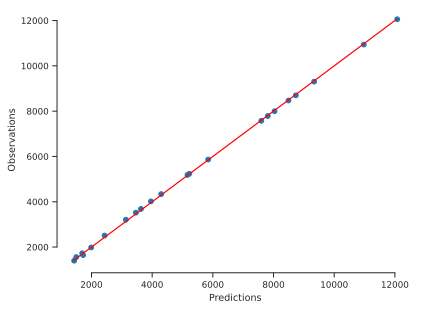

In [ ]:
# your code here
fig, ax = plt.subplots()
ax.plot(y_predict, y_valid, 'o')
yys = np.linspace(
    y_valid.min(),
    y_valid.max(),
    100)
ax.plot(yys, yys, 'r-')
ax.set_xlabel('Predictions')
ax.set_ylabel('Observations')
sns.despine(trim=True);

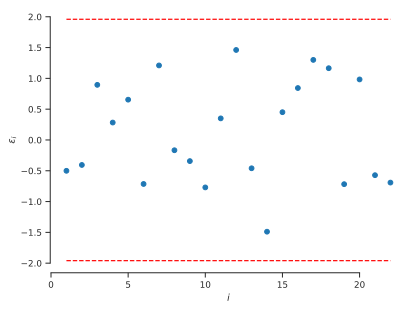

In [ ]:
# your code here
eps = (y_valid - y_predict) / y_std
idx = np.arange(1, eps.shape[0] + 1)

fig, ax = plt.subplots()
ax.plot(idx, eps, 'o', label='Standarized errors')
ax.plot(idx, 1.96 * np.ones(eps.shape[0]), 'r--')
ax.plot(idx, -1.96 * np.ones(eps.shape[0]), 'r--')
ax.set_xlabel('$i$')
ax.set_ylabel('$\epsilon_i$')
sns.despine(trim=True);

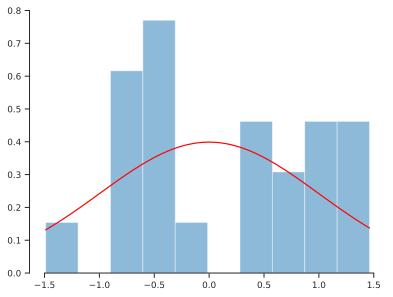

In [ ]:
import scipy.stats as st

fig, ax = plt.subplots()
ax.hist(eps, alpha=0.5, density=True)
ee = np.linspace(eps.min(), eps.max(), 100)
ax.plot(ee, st.norm.pdf(ee), 'r')
sns.despine(trim=True);

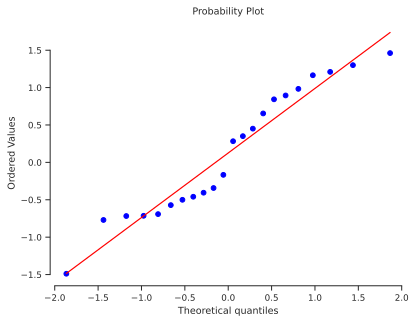

In [ ]:
# your code here
fig, ax = plt.subplots()
st.probplot(eps, dist=st.norm, plot=ax)
sns.despine(trim=True);

### Subpart A.II

What is the noise variance you estimated for the Capacity?

In [ ]:
# your code here
# the "Estimated precision of the noise."
sigma = np.sqrt(1.0 / model.alpha_)
print('sigma = {0:1.2f}'.format(sigma))

sigma = 47.29


### Subpart A.III
Which features of the temperatures (basis functions of your model) are the most important for predicting the Capacity?

Prior w precision: {alpha}


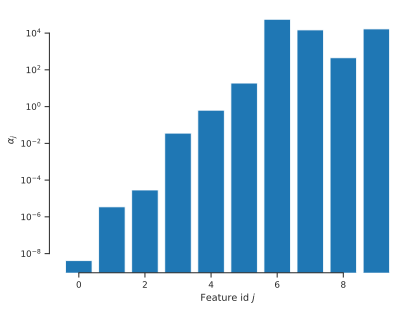

In [ ]:
# your code here
alpha = model.lambda_
print("Prior w precision: {alpha}")

fig, ax = plt.subplots()
ax.bar(np.arange(10), alpha)
ax.set_xlabel('Feature id $j$')
ax.set_ylabel(r'$\alpha_j$')
ax.set_yscale("log")
# ax.set_title(f'$n={num_obs}$')
sns.despine(trim=True);

The higher the prior precision $\alpha_j$ of a weight, the more its prior (and consequently the posterior) concentrates about zero.

The corresponding weight is essentially zero for extremely high values of prior precision.

ARD tells us that we don’t have to include the 6th, 7th, 8th, and 9th-degree monomials.



---



---





### Subpart B.I - Fit the Power

Please don't just fit. Split in training and test and use all the usual diagnostics.

In [ ]:
# your code here - Repeat as many text and code blocks as you like
# Here is how to extract the T_e and T_c columns and put them in a single numpy array
x = data[['T_e','T_c']].values
# x
# Here is how to extract the Power
y = data['Power'].values
# y
# your code here - Repeat as many text and code blocks as you like
from sklearn.model_selection import train_test_split
x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=0.33, random_state=42)
print(f"Training Data Shape: {x_train.shape, y_train.shape}")
print(f"Validation Data Shape: {x_valid.shape, y_valid.shape}")

Training Data Shape: ((43, 2), (43,))
Validation Data Shape: ((22, 2), (22,))


In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import ARDRegression

# Parameters
degree = 3

# Design matrix
poly = PolynomialFeatures(degree)
# print(poly)
x_train = poly.fit_transform(x_train)
# print(x_train)
# Fit
model = ARDRegression(
    fit_intercept=False
).fit(x_train, y_train)

In [ ]:
# your code here
poly_valid = poly.fit_transform(x_valid)

y_predict, y_std = model.predict(
    poly_valid,
    return_std=True
)

MSE_val = np.mean((y_predict - y_valid) ** 2)
print(f'MSE of Validation Data = {MSE_val:1.2f}')

MSE of Validation Data = 1031.12


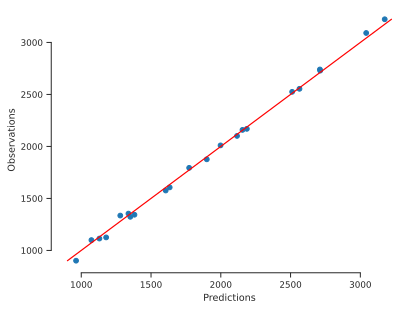

In [ ]:
# your code here
fig, ax = plt.subplots()
ax.plot(y_predict, y_valid, 'o')
yys = np.linspace(
    y_valid.min(),
    y_valid.max(),
    100)
ax.plot(yys, yys, 'r-')
ax.set_xlabel('Predictions')
ax.set_ylabel('Observations')
sns.despine(trim=True);

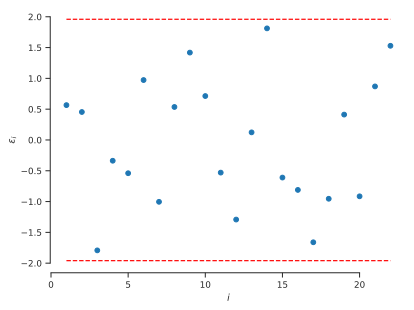

In [ ]:
# your code here
eps = (y_valid - y_predict) / y_std
idx = np.arange(1, eps.shape[0] + 1)

fig, ax = plt.subplots()
ax.plot(idx, eps, 'o', label='Standarized errors')
ax.plot(idx, 1.96 * np.ones(eps.shape[0]), 'r--')
ax.plot(idx, -1.96 * np.ones(eps.shape[0]), 'r--')
ax.set_xlabel('$i$')
ax.set_ylabel('$\epsilon_i$')
sns.despine(trim=True);

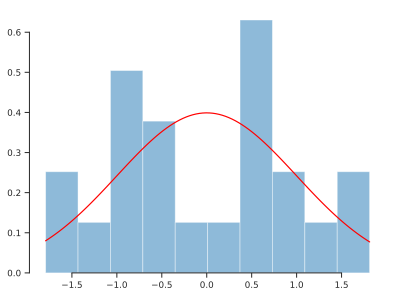

In [ ]:
import scipy.stats as st

fig, ax = plt.subplots()
ax.hist(eps, alpha=0.5, density=True)
ee = np.linspace(eps.min(), eps.max(), 100)
ax.plot(ee, st.norm.pdf(ee), 'r')
sns.despine(trim=True);

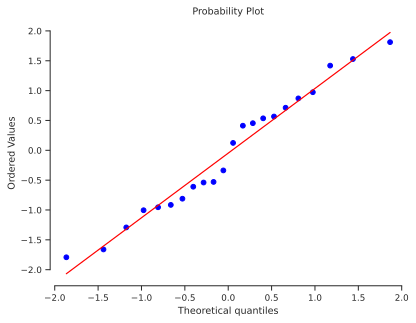

In [ ]:
# your code here
fig, ax = plt.subplots()
st.probplot(eps, dist=st.norm, plot=ax)
sns.despine(trim=True);

### Subpart B.II

What is the noise variance you estimated for the Power?

In [ ]:
# your code here
# the "Estimated precision of the noise."
sigma = np.sqrt(1.0 / model.alpha_)
print('sigma = {0:1.2f}'.format(sigma))

sigma = 28.00


### Subpart B.III
Which features of the temperatures (basis functions of your model) are the most important for predicting the Power?

Prior w precision: {alpha}


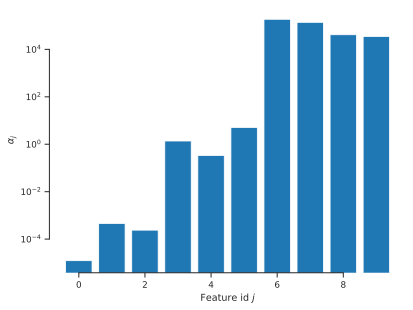

In [ ]:
# your code here
alpha = model.lambda_
print("Prior w precision: {alpha}")

fig, ax = plt.subplots()
ax.bar(np.arange(10), alpha)
ax.set_xlabel('Feature id $j$')
ax.set_ylabel(r'$\alpha_j$')
ax.set_yscale("log")
# ax.set_title(f'$n={num_obs}$')
sns.despine(trim=True);

ARD tells us that we don’t have to include the 6th, 7th, 8th, and 9th-degree monomials.



---



---


$\pagebreak$

# Problem 3 - Explaining the Challenger disaster
On January 28, 1986, the [Space Shuttle Challenger](https://en.wikipedia.org/wiki/Space_Shuttle_Challenger_disaster) disintegrated after 73 seconds from launch.
The failure can be traced to the rubber O-rings, which were used to seal the joints of the solid rocket boosters (required to force the hot, high-pressure gases generated by the burning solid propellant through the nozzles, thus producing thrust).

The performance of the O-ring material was sensitive to the external temperature during launch.
This [dataset](https://raw.githubusercontent.com/PredictiveScienceLab/data-analytics-se/master/homework/challenger_data.csv) contains records of different experiments with O-rings recorded at various times between 1981 and 1986.
Download the data the usual way (either put them on Google Drive or run the code cell below).

In [ ]:
url = "https://github.com/PredictiveScienceLab/data-analytics-se/raw/master/lecturebook/data/challenger_data.csv"
download(url)

Even though this is a CSV file, you should load it with pandas because it contains some special characters.

In [ ]:
raw_data = pd.read_csv('challenger_data.csv')
raw_data

,Date,Temperature,Damage Incident
0,04/12/1981,66,0
1,11/12/1981,70,1
2,3/22/82,69,0
3,6/27/82,80,NaN
4,01/11/1982,68,0
5,04/04/1983,67,0
6,6/18/83,72,0
7,8/30/83,73,0
8,11/28/83,70,0
9,02/03/1984,57,1


The first column is the date of the record. The second column is the external temperature of that day in degrees F.
The third column labeled ``Damage Incident`` has a binary coding (0=no damage, 1=damage).
The very last row is the day of the Challenger accident.

We will use the first 23 rows to solve a binary classification problem that will give us the probability of an accident conditioned on the observed external temperature in degrees F. Before proceeding to the data analysis, let's clean the data up.

First, we drop all the bad records:

In [ ]:
clean_data_0 = raw_data.dropna()
clean_data_0

,Date,Temperature,Damage Incident
0,04/12/1981,66,0
1,11/12/1981,70,1
2,3/22/82,69,0
4,01/11/1982,68,0
5,04/04/1983,67,0
6,6/18/83,72,0
7,8/30/83,73,0
8,11/28/83,70,0
9,02/03/1984,57,1
10,04/06/1984,63,1


We also don't need the last record. Remember that the temperature on the day of the Challenger accident was 31 degrees F.

In [ ]:
clean_data = clean_data_0[:-1]
clean_data

,Date,Temperature,Damage Incident
0,04/12/1981,66,0
1,11/12/1981,70,1
2,3/22/82,69,0
4,01/11/1982,68,0
5,04/04/1983,67,0
6,6/18/83,72,0
7,8/30/83,73,0
8,11/28/83,70,0
9,02/03/1984,57,1
10,04/06/1984,63,1


Let's extract the features and the labels:

In [ ]:
x = clean_data['Temperature'].values
x

array([66, 70, 69, 68, 67, 72, 73, 70, 57, 63, 70, 78, 67, 53, 67, 75, 70,
       81, 76, 79, 75, 76, 58])

In [ ]:
y = clean_data['Damage Incident'].values.astype(float)
y

array([0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 1., 0., 1.])

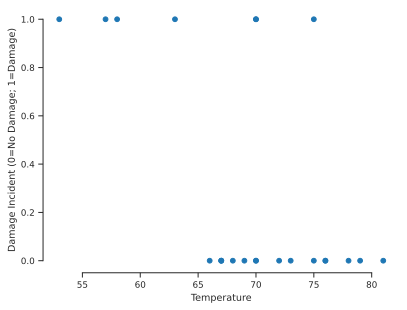

In [ ]:
fig, ax = plt.subplots()
ax.plot(x, y, 'o')
ax.set_xlabel('Temperature')
ax.set_ylabel('Damage Incident (0=No Damage; 1=Damage)')
sns.despine(trim=True);

## Part A - Perform logistic regression

Perform logistic regression between the temperature ($x$) and the damage label ($y$).
Refrain from validating because there is little data.
Just use a simple model so that you don't overfit.

In [ ]:
# your code here - Repeat as many text and code blocks as you like
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression

# Design matrix
poly = PolynomialFeatures(2)
Phi = poly.fit_transform(x[:, None])

# Fit
model = LogisticRegression(
    penalty=None,
    fit_intercept=False
).fit(Phi, y)

## Part B - Plot the probability of damage as a function of temperature
Plot the probability of damage as a function of temperature.

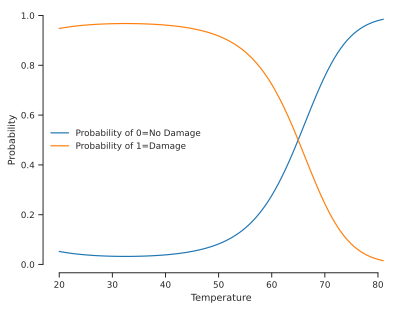

In [ ]:
fig, ax = plt.subplots()
xx = np.linspace(20, x.max(), 100)
Phi_xx = poly.fit_transform(xx[:, None])
predictions_xx = model.predict_proba(Phi_xx)
ax.plot(
    xx,
    predictions_xx[:, 0],
    label='Probability of 0=No Damage'
)
ax.plot(
    xx,
    predictions_xx[:, 1],
    label='Probability of 1=Damage'
)
ax.set_xlabel('Temperature')
ax.set_ylabel('Probability')
plt.legend(loc='best', frameon=False)
sns.despine(trim=True);

## Part C - Decide whether or not to launch

The temperature on the day of the Challenger accident was 31 degrees F.
Start by calculating the probability of damage at 31 degrees F.
Then, use formal decision-making (i.e., define a cost matrix and make decisions by minimizing the expected loss) to decide whether or not to launch on that day.
Also, plot your optimal decision as a function of the external temperature.

In [ ]:
failure = np.array([31],ndmin=2)
# print(failure)
Phi_fail = poly.fit_transform(failure)
pred_31 = model.predict_proba(Phi_fail)
# print(pred_31)

print('Temperature\tp(y=0|x)\tp(y=1|x)\tTrue label')
print('-' * 80)
print(
        f"{failure[0][0]:1.2f}\t\t"
        + f"{pred_31[0][0]:1.2f}\t\t"
        + f"{pred_31[0][1]:1.2f}\t\t"
        + f"{1.0}"
    )

Temperature	p(y=0|x)	p(y=1|x)	True label
--------------------------------------------------------------------------------
31.00		0.03		0.97		1.0


In [ ]:
Phi_valid = poly.fit_transform(x[:, None])
predictions = model.predict_proba(Phi_valid)
print('Temperature\tp(y=0|x)\tp(y=1|x)\tTrue label')
print('-' * 80)
for i in range(x.shape[0]):
    print(
        f"{x[i]:1.2f}\t\t"
        + f"{predictions[i, 0]:1.2f}\t\t"
        + f"{predictions[i, 1]:1.2f}\t\t"
        + f"{y[i]:f}"
    )

Temperature	p(y=0|x)	p(y=1|x)	True label
--------------------------------------------------------------------------------
66.00		0.55		0.45		0.000000
70.00		0.76		0.24		1.000000
69.00		0.71		0.29		0.000000
68.00		0.66		0.34		0.000000
67.00		0.61		0.39		0.000000
72.00		0.84		0.16		0.000000
73.00		0.87		0.13		0.000000
70.00		0.76		0.24		0.000000
57.00		0.19		0.81		1.000000
63.00		0.40		0.60		1.000000
70.00		0.76		0.24		1.000000
78.00		0.96		0.04		0.000000
67.00		0.61		0.39		0.000000
53.00		0.11		0.89		1.000000
67.00		0.61		0.39		0.000000
75.00		0.92		0.08		0.000000
70.00		0.76		0.24		0.000000
81.00		0.98		0.02		0.000000
76.00		0.94		0.06		0.000000
79.00		0.97		0.03		0.000000
75.00		0.92		0.08		1.000000
76.00		0.94		0.06		0.000000
58.00		0.21		0.79		1.000000


In [ ]:
# c_00 = cost of correctly picking 0 when 0 is true
# c_01 = cost of wrongly picking 0 when 1 is true
# c_11 = cost of correctly picking 1 when 1 is true
# c_10 = cost of wrongly picking 1 when 0 is true
cost_matrix = np.array(
    [
        [0, 10**7],
        [10**6, 0]
    ]
)

In [ ]:
def expected_cost(cost_matrix, prediction_prob):
    """Calculate the expected cost of each decision.

    Arguments
    cost_matrix     --  A D x D matrix. `cost_matrix[i, j]`
                        is the cost of picking `i` and then
                        `j` happens.
    prediction_prob --  An array with D elements containing
                        the probability that each event
                        happens.
    """
    assert cost_matrix.ndim == 2
    D = cost_matrix.shape[0]
    assert cost_matrix.shape[1] == D
    assert prediction_prob.ndim == 1
    assert prediction_prob.shape[0] == D
    res = np.zeros((2,))
    for i in range(2):
        res[i] = (
            cost_matrix[i, 0] * prediction_prob[0]
            + cost_matrix[i, 1] * prediction_prob[1]
        )
    return res

In [ ]:
print('Temperature\tCost of 0\t\tCost of 1\t\tTrue label\tChoice')
print('-' * 100)
for i in range(x.shape[0]):
    exp_c = expected_cost(cost_matrix, predictions[i])
    line = f'{x[i]:1.2f}\t\t{exp_c[0]:1.2f}'
    tmp = f'\t\t{exp_c[1]:1.2f}'
    correct_choice = True
    if exp_c[0] < exp_c[1]:
        line += '*'
        if y[i] == 1:
            correct_choice = False
    else:
        tmp += '*'
        if y[i] == 0:
            correct_choice = False
    line += tmp + f'\t\t{y[i]}'
    if correct_choice:
        line += '\t\tCORRECT'
    else:
        line += '\t\tWRONG'
    print(line)

Temperature	Cost of 0		Cost of 1		True label	Choice
----------------------------------------------------------------------------------------------------
66.00		4459447.37		554055.26*		0.0		WRONG
70.00		2439436.51		756056.35*		1.0		CORRECT
69.00		2904906.13		709509.39*		0.0		WRONG
68.00		3404568.82		659543.12*		0.0		WRONG
67.00		3927069.41		607293.06*		0.0		WRONG
72.00		1642652.52		835734.75*		0.0		WRONG
73.00		1318954.39		868104.56*		0.0		WRONG
70.00		2439436.51		756056.35*		0.0		WRONG
57.00		8120476.33		187952.37*		1.0		CORRECT
63.00		5989207.97		401079.20*		1.0		CORRECT
70.00		2439436.51		756056.35*		1.0		CORRECT
78.00		366797.51*		963320.25		0.0		CORRECT
67.00		3927069.41		607293.06*		0.0		WRONG
53.00		8852369.20		114763.08*		1.0		CORRECT
67.00		3927069.41		607293.06*		0.0		WRONG
75.00		817691.88*		918230.81		0.0		CORRECT
70.00		2439436.51		756056.35*		0.0		WRONG
81.00		151324.31*		984867.57		0.0		CORRECT
76.00		632500.80*		936749.92		0.0		CORRECT
79.00		275389.02*		972461.10		0.0		

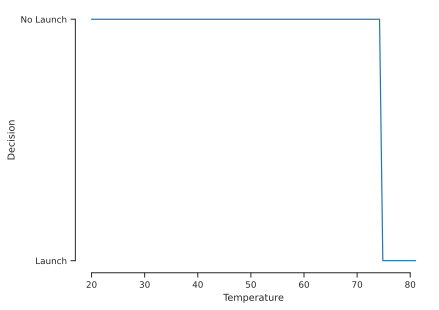

In [ ]:
# your code here - Repeat as many text and code blocks as you like
fig, ax = plt.subplots()
exp_cost = np.einsum('ij,kj->ki', cost_matrix, predictions_xx)
decision_idx = np.argmin(exp_cost, axis=1)
ax.plot(xx, decision_idx)
ax.set_yticks([0, 1])
ax.set_yticklabels(['Launch', 'No Launch'])
ax.set_ylabel('Decision')
ax.set_xlabel('Temperature')
sns.despine(trim=True)

In my cost matrix, I have penalized wrong predictions and not correct predictions. The penalty for wrong prediction is based on cost of human life estimates.
The decision boundary plot indicates that it is safe to launch the shuttle if the Temperature is above 71 degrees F.

---



---

